In [262]:
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage.feature import hog

In [263]:
data_dir = pathlib.Path('./output/rgb')
# data_dir = pathlib.Path('./output/rgb_no_circle_det')
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

34


In [264]:
from skimage.feature import SIFT
from skimage import exposure
from skimage.color import rgb2gray, gray2rgb

def sift_features_vector(src, image_path, height_map=None):
    src = rgb2gray(src)
    img_adapteq = exposure.equalize_adapthist(src, clip_limit=0.03)
    print(img_adapteq.shape)
    descriptor_extractor = SIFT()
    # descriptor_extractor = ORB(n_keypoints=50)
    descriptor_extractor.detect_and_extract(img_adapteq)
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors
    
    # random select 100 keypoints
    # random_keypoints = np.random.randint(0, len(keypoints), 50) 
    # random_keypoints = np.random.randint(0, len(keypoints), 200) # DMMP
    # random_keypoints = np.random.randint(0, len(keypoints), 500) # MP
    # random_keypoints = np.random.randint(0, len(keypoints), 1000) # MP
    random_keypoints = np.random.randint(0, len(keypoints), 2500) # for statics
    keypoints = keypoints[random_keypoints]
    descriptors = descriptors[random_keypoints]
    
    height_value = []
    if height_map is not None:
        for i in range(len(keypoints)):
            height = height_map[int(keypoints[i][0]), int(keypoints[i][1])]
            height_value.append(height)
    
    plt.imshow(img_adapteq, cmap='gray')
    plt.scatter(keypoints[:, 1], keypoints[:, 0],
                facecolors='none', edgecolors='r')
    plt.savefig('./output/sift/%s' % (image_path))
    plt.close()
    if height_map is not None:
        descriptors = np.hstack((descriptors, np.array(height_value).reshape(-1, 1)))
    print(descriptors.shape)
    return descriptors, keypoints

C:\Users\moon9\AppData\Local\Temp\ipykernel_67180\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



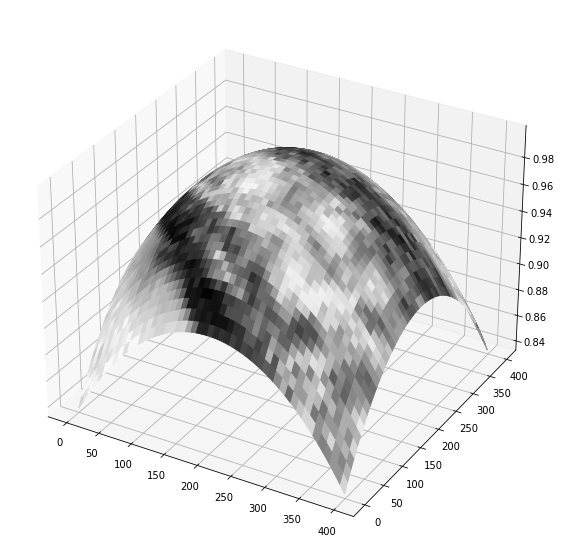

In [265]:
def generate_height_map(size):
    # Define the radius of the sphere
    # offset = 0
    # offset = 175
    offset = 315
    size = size + 2*offset

    r = 1.0

    # Create a 2D grid of x and y coordinates
    x, y = np.meshgrid(np.linspace(-r, r, size), np.linspace(-r, r, size))

    # Calculate the corresponding z coordinates
    # Note: For points outside the sphere, this will be NaN
    z = np.sqrt(r**2 - x**2 - y**2)

    # We set points outside the sphere to zero height for visualization
    z[np.isnan(z)] = 0

    z = z[offset:size-offset, offset:size-offset]

    return z
# visualise the height map in 3D
height_map = generate_height_map(400)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create the x, y, and z coordinate arrays. We use 
# numpy's broadcasting to do all the hard work for us.
# We could shorten this even more by using np.meshgrid.
x = np.arange(height_map.shape[0])
y = np.arange(height_map.shape[1])
x, y = np.meshgrid(x, y)
z = height_map

# Load the image
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('./output/rgb/M-DMMP- NaBF4-10-6M-1.jpg')
image = rgb2gray(image)
image = exposure.equalize_adapthist(image, clip_limit=0.03)
image = gray2rgb(image)
height, width = image.shape[:2]
resize_image = cv2.resize(src=image, dsize=(int(width / 2), int(height / 2)))
resize_image = resize_image[50:450, 50:450]

# Map the image to the surface
ax.plot_surface(x, y, z, facecolors=image, shade=False)

plt.show()

In [266]:
import os
from sklearn.model_selection import train_test_split

rotation_aug = False

experiment_with_gray_scale = True

use_entire_dataset = True

load_all_images = False

use_height_map = True

distraction_merge, distraction_merge_to_one, original_merge_to_one = False, False, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, True, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = True, False, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, False, True
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, True, True
# distraction_merge, distraction_merge_to_one, original_merge_to_one = True, False, True

os.makedirs('./output/sift', exist_ok=True)

# Data selection
molecular_imprinting_name = 'DMMP'
# molecular_imprinting_name = 'MP'
# molecular_imprinting_name = 'MPA'
x = []
y = []
for path in data_dir.glob('*.jpg'):
    if not load_all_images:
        if path.name.split('-')[1] != molecular_imprinting_name and path.name.split('-')[1].split('(')[0] != molecular_imprinting_name:
                continue
    src = cv2.imread(str(path))
    height, width = src.shape[:2]
    center = (width / 2, height / 2)
    if rotation_aug:
        for i in range(3):
            rotation_matrix = rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=90 * i, scale=1)
            rotated_image = cv2.warpAffine(src=src, M=rotate_matrix, dsize=(width, height))
            resize_image = cv2.resize(src=src, dsize=(int(width / 2), int(height / 2)))
            # crop image 200x200
            resize_image = resize_image[150:350, 150:350]
            if use_height_map:
                height_map = generate_height_map(200)
                resize_image = np.dstack((resize_image.astype(np.float32), height_map))
            feature_vector = sift_features_vector(resize_image, os.path.basename(path))
            x.append(feature_vector)
            y.append(path.name.split('-')[2].replace(' ', ''))
    else:
        resize_image = cv2.resize(src=src, dsize=(int(width / 2), int(height / 2)))
        # crop image 200x200
        resize_image = resize_image[50:450, 50:450]
        if use_height_map:
            height_map = generate_height_map(400)
        else:
            height_map = None
        feature_vector, keypoints = sift_features_vector(resize_image, os.path.basename(path), height_map=height_map)
        x.append(keypoints)
        if load_all_images:
            label_name = path.name.split('-')[1].split('(')[0] + '-' + path.name.split('-')[2].replace(' ', '')
            if label_name.split('-')[0] != label_name.split('-')[1]:
                if distraction_merge or distraction_merge_to_one:
                    if distraction_merge_to_one:
                        label_name = 'distraction'
                    else:
                        label_name = label_name.split('-')[0] + '-distraction'
            elif label_name.split('-')[0] == label_name.split('-')[1]:
                if original_merge_to_one :
                    label_name = 'original'
        else:
            if distraction_merge or distraction_merge_to_one:
                if path.name.split('-')[2].split('(')[0] != molecular_imprinting_name:
                    if distraction_merge_to_one:
                        label_name = 'distraction'
                    else:
                        label_name = path.name.split('-')[1].split('(')[0] + '-distraction'
                else:
                    label_name = path.name.split('-')[2].replace(' ', '')
            else:
                label_name = path.name.split('-')[2].replace(' ', '')
        y.append(label_name)
        
x = np.array(x)
y = np.array(y)
print('data loaded x=%i' % (len(x)))
print('data loaded y=%i' % (len(y)))

(400, 400)


C:\Users\moon9\AppData\Local\Temp\ipykernel_67180\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(2500, 129)
(400, 400)
(2500, 129)
(400, 400)
(2500, 129)
(400, 400)
(2500, 129)
(400, 400)
(2500, 129)
(400, 400)
(2500, 129)
(400, 400)
(2500, 129)
(400, 400)
(2500, 129)
(400, 400)
(2500, 129)
(400, 400)
(2500, 129)
data loaded x=10
data loaded y=10


In [267]:
print(x.shape)

(10, 2500, 2)


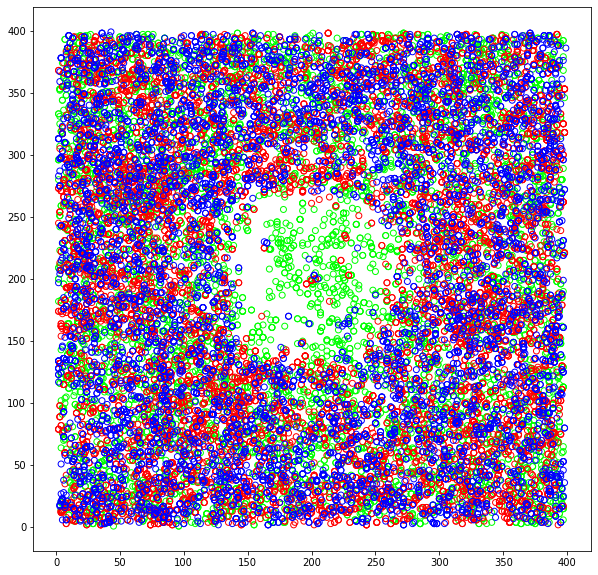

In [268]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x and y are defined properly
# x should be a list of arrays with shape (N, 2), where N is the number of keypoints
# y should be a list of strings corresponding to the labels of each point in x

# Corrected color map in RGB format
color_discrete_map = {
    "DMMP": [255, 0, 0],  # Red
    "NaBF4": [0, 255, 0],  # Green
    "KF6P": [0, 0, 255],  # Blue
    "MPA": [255, 165, 42],  # Goldenrod
    "MP": [128, 0, 128]  # Purple
}

fig = plt.figure(figsize=(10, 10))

# Ensure x and y have the same length
assert len(x) == len(y), "x and y must have the same length"

# Iterate over the keypoints
for i in range(len(x)):
    # Get the label for the current keypoint
    label = y[i]

    # Get the color for the current label
    color = color_discrete_map[label]

    # Convert color to RGB format for matplotlib
    color_rgb = [c / 255.0 for c in color]

    # Get the coordinates of the current keypoint
    coordinates = x[i]

    # Scatter plot for keypoints
    plt.scatter(coordinates[:, 1], coordinates[:, 0], facecolors='none', edgecolors=color_rgb)

# Display the plot
plt.show()


In [269]:
# Assuming y is a list of strings corresponding to the labels of each point in x

# Initialize a dictionary to store the counts
keypoints_counts = {label: 0 for label in set(y)}

# Iterate over the labels
for label in y:
    # Increment the count for the current label
    keypoints_counts[label] += 1

# Print the total number of keypoints for each class
for label, count in keypoints_counts.items():
    print(f"Total number of keypoints for class {label}: {count}")

Total number of keypoints for class NaBF4: 3
Total number of keypoints for class DMMP: 4
Total number of keypoints for class KF6P: 3


In [270]:
import plotly.io as pio

print(pio.templates)
pio.templates.default = 'plotly'

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']



In [271]:
import numpy as np
import plotly.graph_objects as go

# Assuming y is a list of strings corresponding to the labels of each point in x
# Corrected color map in RGB format
color_discrete_map = {
    "DMMP": 'red',
    "NaBF4": 'green',
    "KF6P": 'blue',
    "MPA": 'gold',
    "MP": 'purple'
}

# Calculate the center of the image
# Assuming all images have the same size
image_center = [200, 200]

angle_bin = 20
radii_bin = 200

# Initialize lists to store all angles and radii for each class
all_angles_classes = {label: [] for label in color_discrete_map.keys()}
all_radii_classes = {label: [] for label in color_discrete_map.keys()}

# Convert keypoints to polar coordinates
for keypoints, label in zip(x, y):
    # Shift keypoints so that the center of the image is the origin
    shifted_keypoints = keypoints - image_center

    # Calculate the angles and radii
    angles = np.arctan2(shifted_keypoints[:, 0], shifted_keypoints[:, 1])
    angles_in_degree = np.rad2deg(angles)
    radii = np.hypot(shifted_keypoints[:, 0], shifted_keypoints[:, 1])
    
    hist, edges = np.histogram(angles_in_degree, bins=angle_bin)
    angles_hist_min_index = np.argmin(hist)
    offset = edges[angles_hist_min_index]
    print('alightment found = %s' % offset)
    angles_in_degree = angles_in_degree + offset
    
    angle = np.deg2rad(angles_in_degree)
    
    # Append the angles and radii to the lists if radius <= 200
    for angle, radius in zip(angles, radii):
        if radius <= 200:
            all_angles_classes[label].append(angle)
            all_radii_classes[label].append(radius)

# Calculate the minimum number of keypoints across all classes
min_keypoints = min(len(angles) if len(angles) != 0 else 99999 for angles in all_angles_classes.values())

# Balance the number of keypoints for each class
for label in all_angles_classes.keys():
    if len(all_angles_classes[label]) > min_keypoints:
        # If the number of keypoints is more than the minimum, randomly select keypoints equal to the minimum number
        indices = np.random.choice(len(all_angles_classes[label]), size=min_keypoints, replace=False)
        all_angles_classes[label] = np.array(all_angles_classes[label])[indices]
        all_radii_classes[label] = np.array(all_radii_classes[label])[indices]

# Plot the distribution of angles for each class
fig = go.Figure()
for label, angles in all_angles_classes.items():
    fig.add_trace(go.Histogram(x=angles, name=label, marker_color=color_discrete_map[label], nbinsx=angle_bin))  # Increased number of bin
fig.update_layout(barmode='overlay', title_text='%s Distribution of Angles' % molecular_imprinting_name, xaxis_title_text='Angle (radians)', yaxis_title_text='Frequency')
fig.update_traces(opacity=0.75)
fig.show()

# Plot the distribution of radii for each class
fig = go.Figure()
for label, radii in all_radii_classes.items():
    fig.add_trace(go.Histogram(x=radii, name=label, marker_color=color_discrete_map[label], nbinsx=radii_bin))  # Increased number of bin
fig.update_layout(barmode='overlay', title_text='%s Distribution of Radii' % molecular_imprinting_name , xaxis_title_text='Radius', yaxis_title_text='Frequency')
fig.update_traces(opacity=0.75)
fig.show()

alightment found = 162.12029852583225
alightment found = -107.22754577007927
alightment found = 0.1618507624600909
alightment found = -0.19902626534209844
alightment found = 72.52071137667855
alightment found = -35.57030403271776
alightment found = -89.57840317342439
alightment found = 0.6509763362894319
alightment found = 90.27720303193999
alightment found = 0.43402572487278235


In [272]:
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter1d

# Assuming y is a list of strings corresponding to the labels of each point in x
# Corrected color map in RGB format
color_discrete_map = {
    "DMMP": 'red',
    "NaBF4": 'green',
    "KF6P": 'blue',
    "MPA": 'gold',
    "MP": 'purple'
}

# Calculate the center of the image
# Assuming all images have the same size
image_center = [200, 200]

angle_bin = 45

# Initialize lists to store all angles for each class
all_angles_classes = {label: [] for label in color_discrete_map.keys()}

# Convert keypoints to polar coordinates
for keypoints, label in zip(x, y):
    print(label)
    # Shift keypoints so that the center of the image is the origin
    shifted_keypoints = keypoints - image_center

    # Calculate the angles
    angles = np.arctan2(shifted_keypoints[:, 0], shifted_keypoints[:, 1])
    angles_in_degree = np.rad2deg(angles)

    hist, edges = np.histogram(angles_in_degree, bins=angle_bin)
    angles_hist_min_index = np.argmin(hist)
    offset = edges[angles_hist_min_index]
    print('alignment found = %s' % offset)
    angles_in_degree = angles_in_degree + offset
    # convert all angle into -180 and 180 range
    angles_in_degree = (angles_in_degree + 180) % 360 - 180
    angle = np.deg2rad(angles_in_degree)

    # Append the angles to the lists
    all_angles_classes[label].extend(angle)

to_del = []
for key, value in all_angles_classes.items():
    if sum(value) == 0:
        to_del.append(key)
for key in to_del:
    del all_angles_classes[key]

# Plot the distribution of angles for each class as a smoothed line graph
fig = go.Figure()
for label, angles in all_angles_classes.items():
    print(label)
    hist, bin_edges = np.histogram(angles, bins=angle_bin)
    total_sum = np.sum(hist)
    hist = hist / total_sum
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    smoothed_hist = gaussian_filter1d(hist, sigma=0.01) # 0.5  # Apply Gaussian smoothing
    fig.add_trace(go.Scatter(x=bin_centers, y=smoothed_hist, mode='lines', name=label, line=dict(color=color_discrete_map[label])))

fig.update_layout(title_text='', xaxis_title_text='Angle (radians)', yaxis_title_text='Frequency', showlegend=False)

fig.update_layout(autosize=False,
                      scene_camera_eye=dict(x=1, y=1, z=2),
                      width=500, height=500,
                      margin=dict(l=20, r=20, b=20, t=20)
    )


fig.show()

fig.write_image("output_distribution/%s-line.png" % molecular_imprinting_name, height=500, width=500)

NaBF4
alignment found = -10.716815724455842
NaBF4
alignment found = -27.442116389501678
NaBF4
alignment found = 4.158254078849865
DMMP
alignment found = -4.183133143228616
DMMP
alignment found = 92.4242833439603
DMMP
alignment found = -27.586218698172672
DMMP
alignment found = -83.5960396648417
KF6P
alignment found = -91.01630242516264
KF6P
alignment found = -154.9651086807574
KF6P
alignment found = 4.424380708764488
DMMP
NaBF4
KF6P


In [273]:
# plot line graph for radii
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter1d

# Corrected color map in RGB format
color_discrete_map = {
    "DMMP": 'red',
    "NaBF4": 'green',
    "KF6P": 'blue',
    "MPA": 'gold',
    "MP": 'purple'
}

# Calculate the center of the image
image_center = [200, 200]

radii_bin = 30

# Initialize lists to store all radii for each class
all_radii_classes = {label: [] for label in color_discrete_map.keys()}

# Convert keypoints to polar coordinates
for keypoints, label in zip(x, y):
    # Shift keypoints so that the center of the image is the origin
    shifted_keypoints = keypoints - image_center

    # Calculate the radii
    radii = np.hypot(shifted_keypoints[:, 0], shifted_keypoints[:, 1])

    # Append the radii to the lists if radius <= 200
    for radius in radii:
        if radius <= 200:
            all_radii_classes[label].append(radius)

# Plot the distribution of radii for each class as a smoothed line graph
fig = go.Figure()
for label, radii in all_radii_classes.items():
    hist, bin_edges = np.histogram(radii, bins=radii_bin)
    total_sum = np.sum(hist)
    hist = hist / total_sum
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    smoothed_hist = gaussian_filter1d(hist, sigma=0.01)  # Apply Gaussian smoothing
    fig.add_trace(go.Scatter(x=bin_centers, y=smoothed_hist, mode='lines', name=label, line=dict(color=color_discrete_map[label])))

fig.update_layout(title_text='', xaxis_title_text='Radius', yaxis_title_text='Frequency',showlegend=False)

fig.update_layout(autosize=False,
                      scene_camera_eye=dict(x=1, y=1, z=2),
                      width=500, height=500,
                      margin=dict(l=20, r=20, b=20, t=20)
    )

fig.show()

fig.write_image("output_distribution/%s-radii-line.png" % molecular_imprinting_name, height=500, width=500)

C:\Users\moon9\AppData\Local\Temp\ipykernel_67180\185370244.py:41: RuntimeWarning:

invalid value encountered in true_divide



In [274]:
from scipy.fft import fft, fftfreq

# Apply Fourier Transform to the smoothed data and print the result
for label, angles in all_angles_classes.items():
    hist, bin_edges = np.histogram(angles, bins=angle_bin)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    smoothed_hist = gaussian_filter1d(hist, sigma=0.01)  # Apply Gaussian smoothing

    # Apply Fourier Transform
    yf = fft(smoothed_hist)
    xf = fftfreq(len(smoothed_hist), bin_centers[1] - bin_centers[0])

    print(f"Fourier Transform result for {label}:")
    print("Frequencies:", xf)
    print("Amplitudes:", np.abs(yf))

Fourier Transform result for DMMP:
Frequencies: [ 0.          0.1593063   0.31861259  0.47791889  0.63722518  0.79653148
  0.95583777  1.11514407  1.27445036  1.43375666  1.59306296  1.75236925
  1.91167555  2.07098184  2.23028814  2.38959443  2.54890073  2.70820702
  2.86751332  3.02681961  3.18612591  3.34543221  3.5047385  -3.5047385
 -3.34543221 -3.18612591 -3.02681961 -2.86751332 -2.70820702 -2.54890073
 -2.38959443 -2.23028814 -2.07098184 -1.91167555 -1.75236925 -1.59306296
 -1.43375666 -1.27445036 -1.11514407 -0.95583777 -0.79653148 -0.63722518
 -0.47791889 -0.31861259 -0.1593063 ]
Amplitudes: [10000.           370.17028285   114.06575466   291.73860106
  1140.16714871   348.11523403   310.06014526   349.4180904
   276.25273577   388.27899278    58.43955392   210.32572159
   140.70798888   226.22135012   306.1063126    291.01718162
    61.05300033   381.17145171   353.30500105    94.25708838
   245.79788928   225.63589439   130.93752782   130.93752782
   225.63589439   245.79788

In [275]:
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq

# Assuming y is a list of strings corresponding to the labels of each point in x
# Corrected color map in RGB format
color_discrete_map = {
    "DMMP": 'red',
    "NaBF4": 'green',
    "KF6P": 'blue',
    "MPA": 'gold',
    "MP": 'purple'
}

# Calculate the center of the image
# Assuming all images have the same size
image_center = [200, 200]

angle_bin = 45

# Initialize lists to store all angles for each class
all_angles_classes = {label: [] for label in color_discrete_map.keys()}

# Convert keypoints to polar coordinates
for keypoints, label in zip(x, y):
    # Shift keypoints so that the center of the image is the origin
    shifted_keypoints = keypoints - image_center

    # Calculate the angles
    angles = np.arctan2(shifted_keypoints[:, 0], shifted_keypoints[:, 1])
    angles_in_degree = np.rad2deg(angles)

    hist, edges = np.histogram(angles_in_degree, bins=angle_bin)
    angles_hist_min_index = np.argmin(hist)
    offset = edges[angles_hist_min_index]
    angles_in_degree = angles_in_degree + offset
    # Convert all angles to the range [-180, 180]
    angles_in_degree = (angles_in_degree + 180) % 360 - 180
    angle = np.deg2rad(angles_in_degree)

    # Append the angles to the lists
    all_angles_classes[label].extend(angle)

to_del = []
for key, value in all_angles_classes.items():
    if sum(value) == 0:
        to_del.append(key)
for key in to_del:
    del all_angles_classes[key]

# Apply Fourier Transform to the smoothed data and visualize the result
fig_fft = go.Figure()
for label, angles in all_angles_classes.items():
    hist, bin_edges = np.histogram(angles, bins=angle_bin)
    total_sum = np.sum(hist)
    hist = hist / total_sum 
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    smoothed_hist = gaussian_filter1d(hist, sigma=0.01)  # Apply Gaussian smoothing

    # Apply Fourier Transform
    yf = fft(smoothed_hist)
    xf = fftfreq(len(smoothed_hist), bin_centers[1] - bin_centers[0])
    
    # sort the frequency and amplitude from low to high
    yf = yf[np.argsort(xf)]
    xf = np.sort(xf)
    
    # filter out the negative frequency
    yf = yf[xf > 0]
    xf = xf[xf > 0]
    
    fig_fft.add_trace(go.Scatter(x=xf, y=np.abs(yf), mode='lines', name=label, marker=dict(color=color_discrete_map[label])))

fig_fft.update_layout(title_text='', xaxis_title_text='Frequency', yaxis_title_text='Amplitude', showlegend=False)

fig_fft.update_layout(autosize=False,
                      scene_camera_eye=dict(x=1, y=1, z=2),
                      width=500, height=500,
                      margin=dict(l=20, r=20, b=20, t=20)
    )

fig_fft.show()

fig_fft.write_image("output_distribution/%s-fourier.png" % molecular_imprinting_name, height=500, width=500)

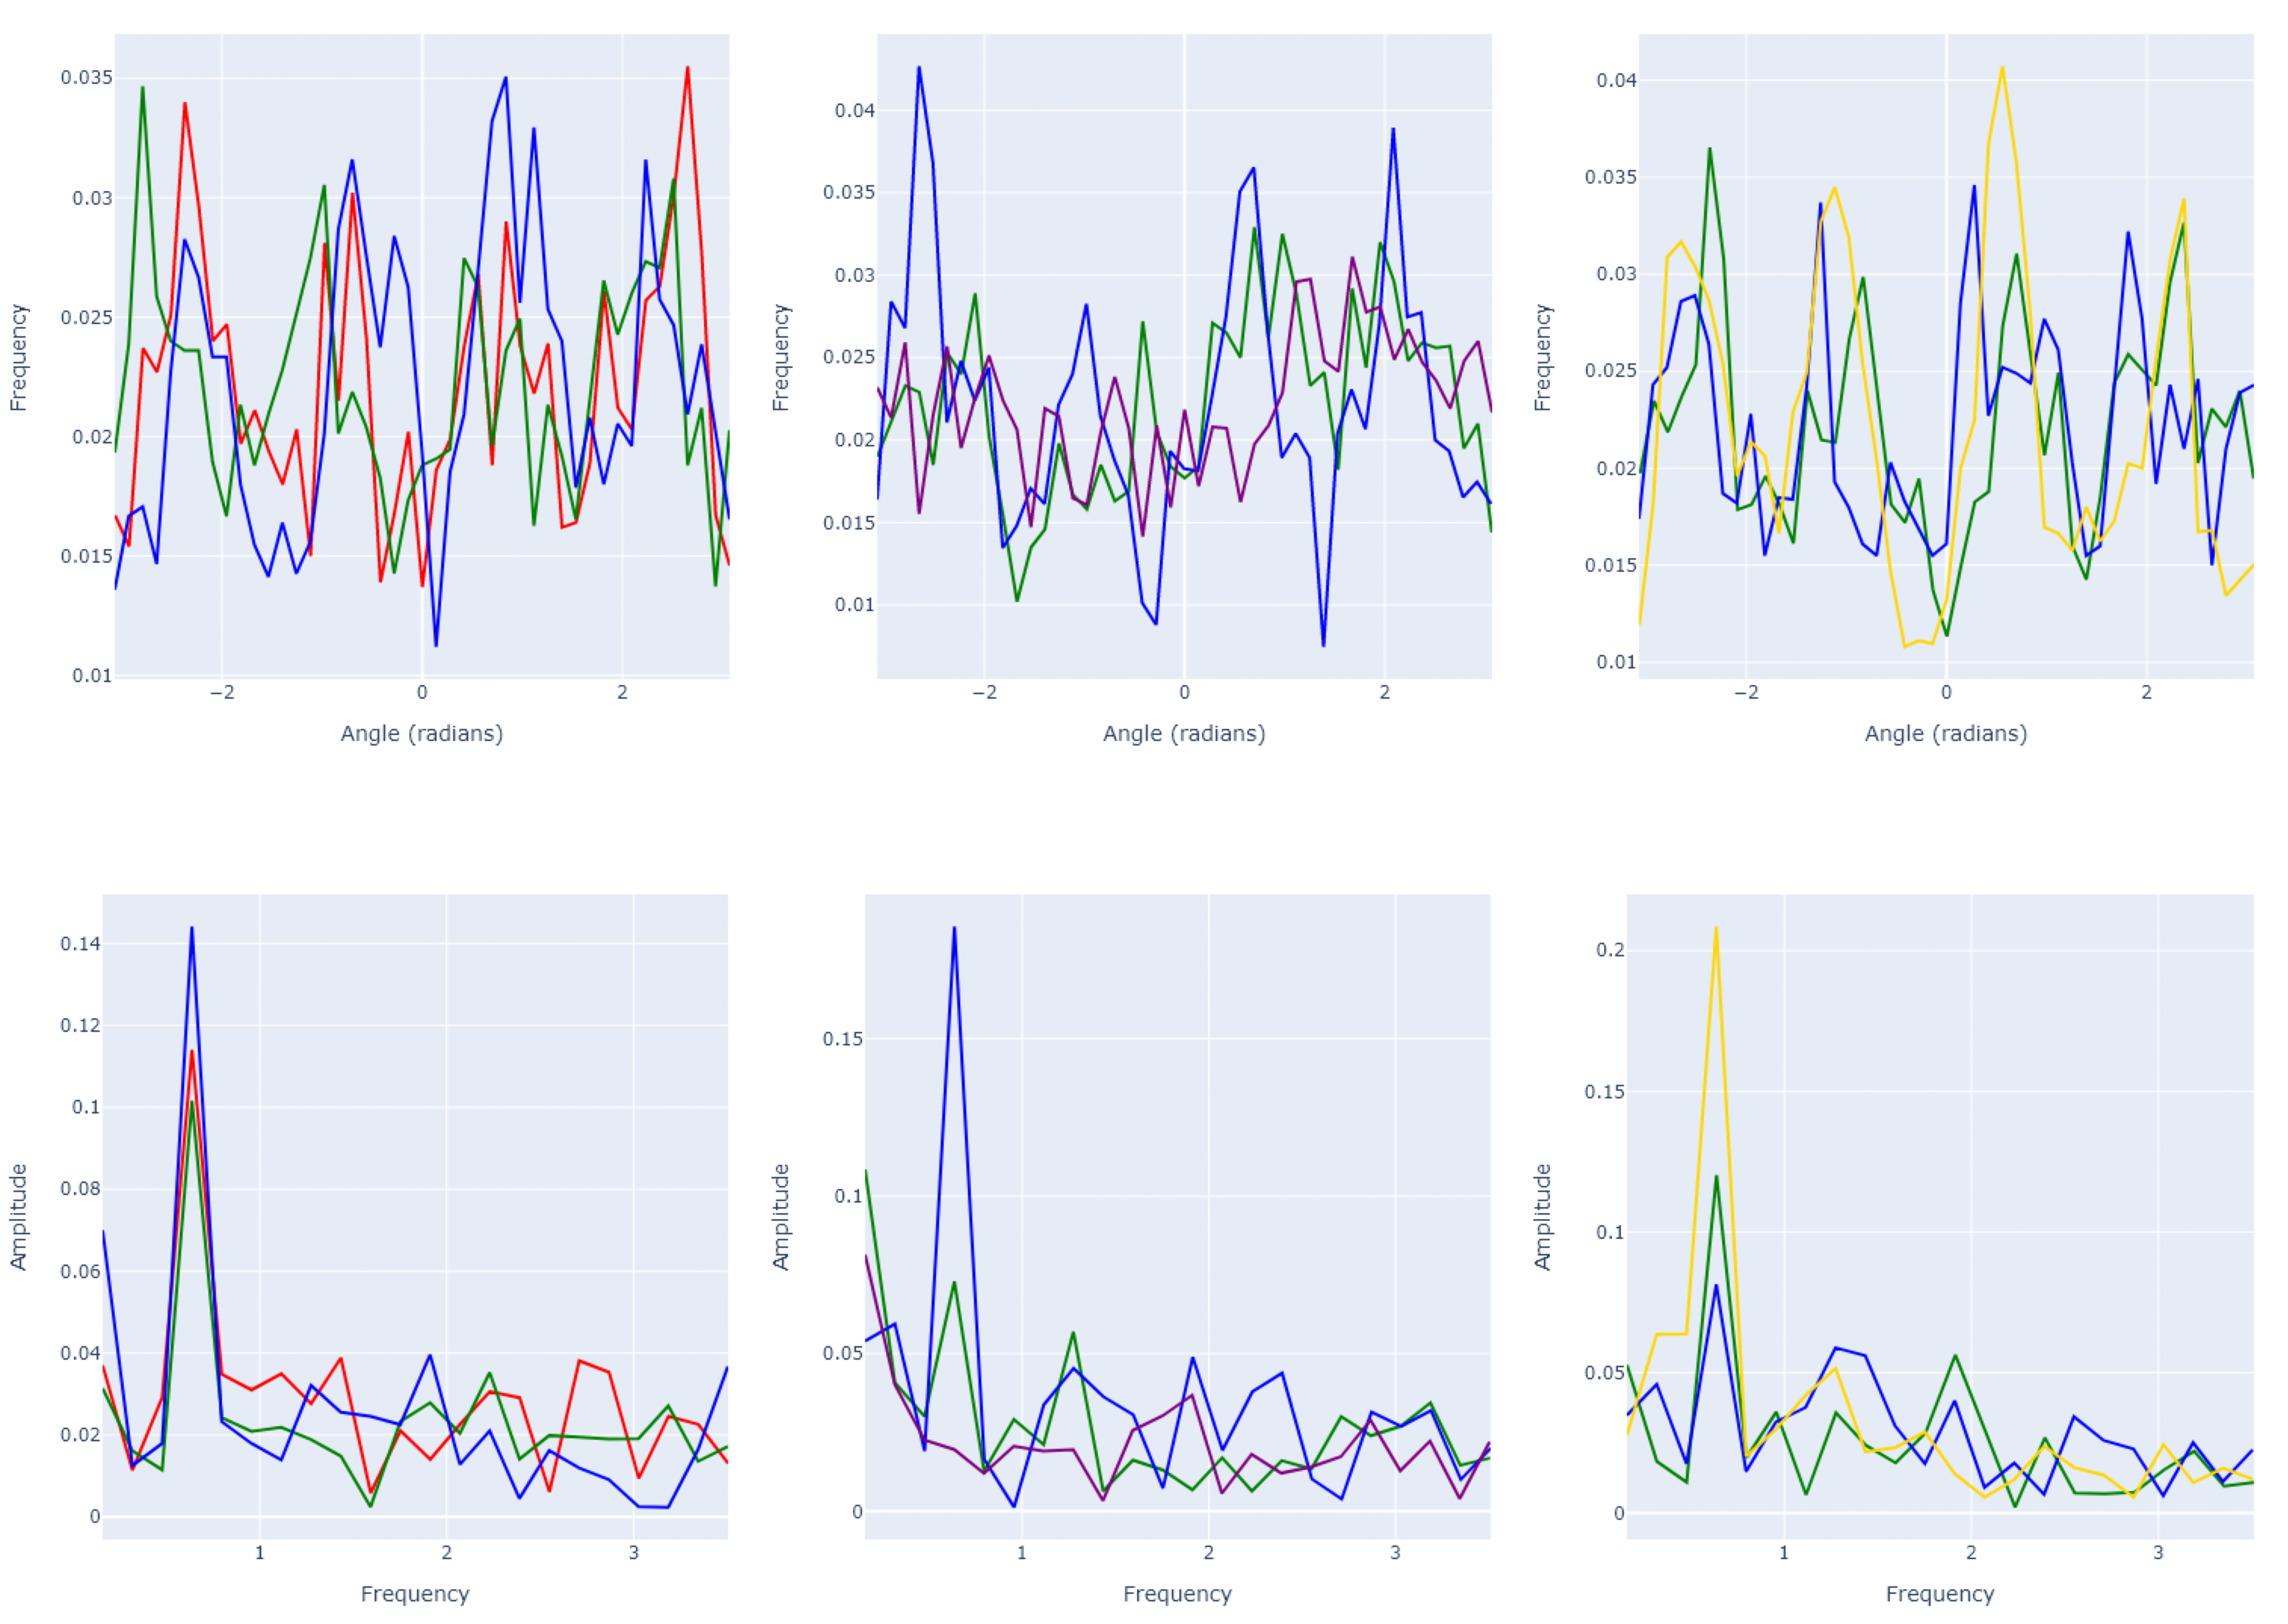

In [281]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of image names
image_names = [
    'DMMP-line', 'MP-line',
    'MPA-line', 'DMMP-fourier',
    'MP-fourier', 'MPA-fourier', 
]

# Create a figure with a 3x3 grid layout
fig, axes = plt.subplots(2, 3, figsize=(50, 40))

# Loop through the image names and add each image to the grid
for i, ax in enumerate(axes.flat):
    img_path = f'./output_distribution/{image_names[i]}.png'
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')  # Remove axis labels and ticks

# Set the background color to white
fig.patch.set_facecolor('white')

# Save the merged image
plt.tight_layout()
plt.savefig('./output_distribution/merged_angle_image.png')
plt.show()

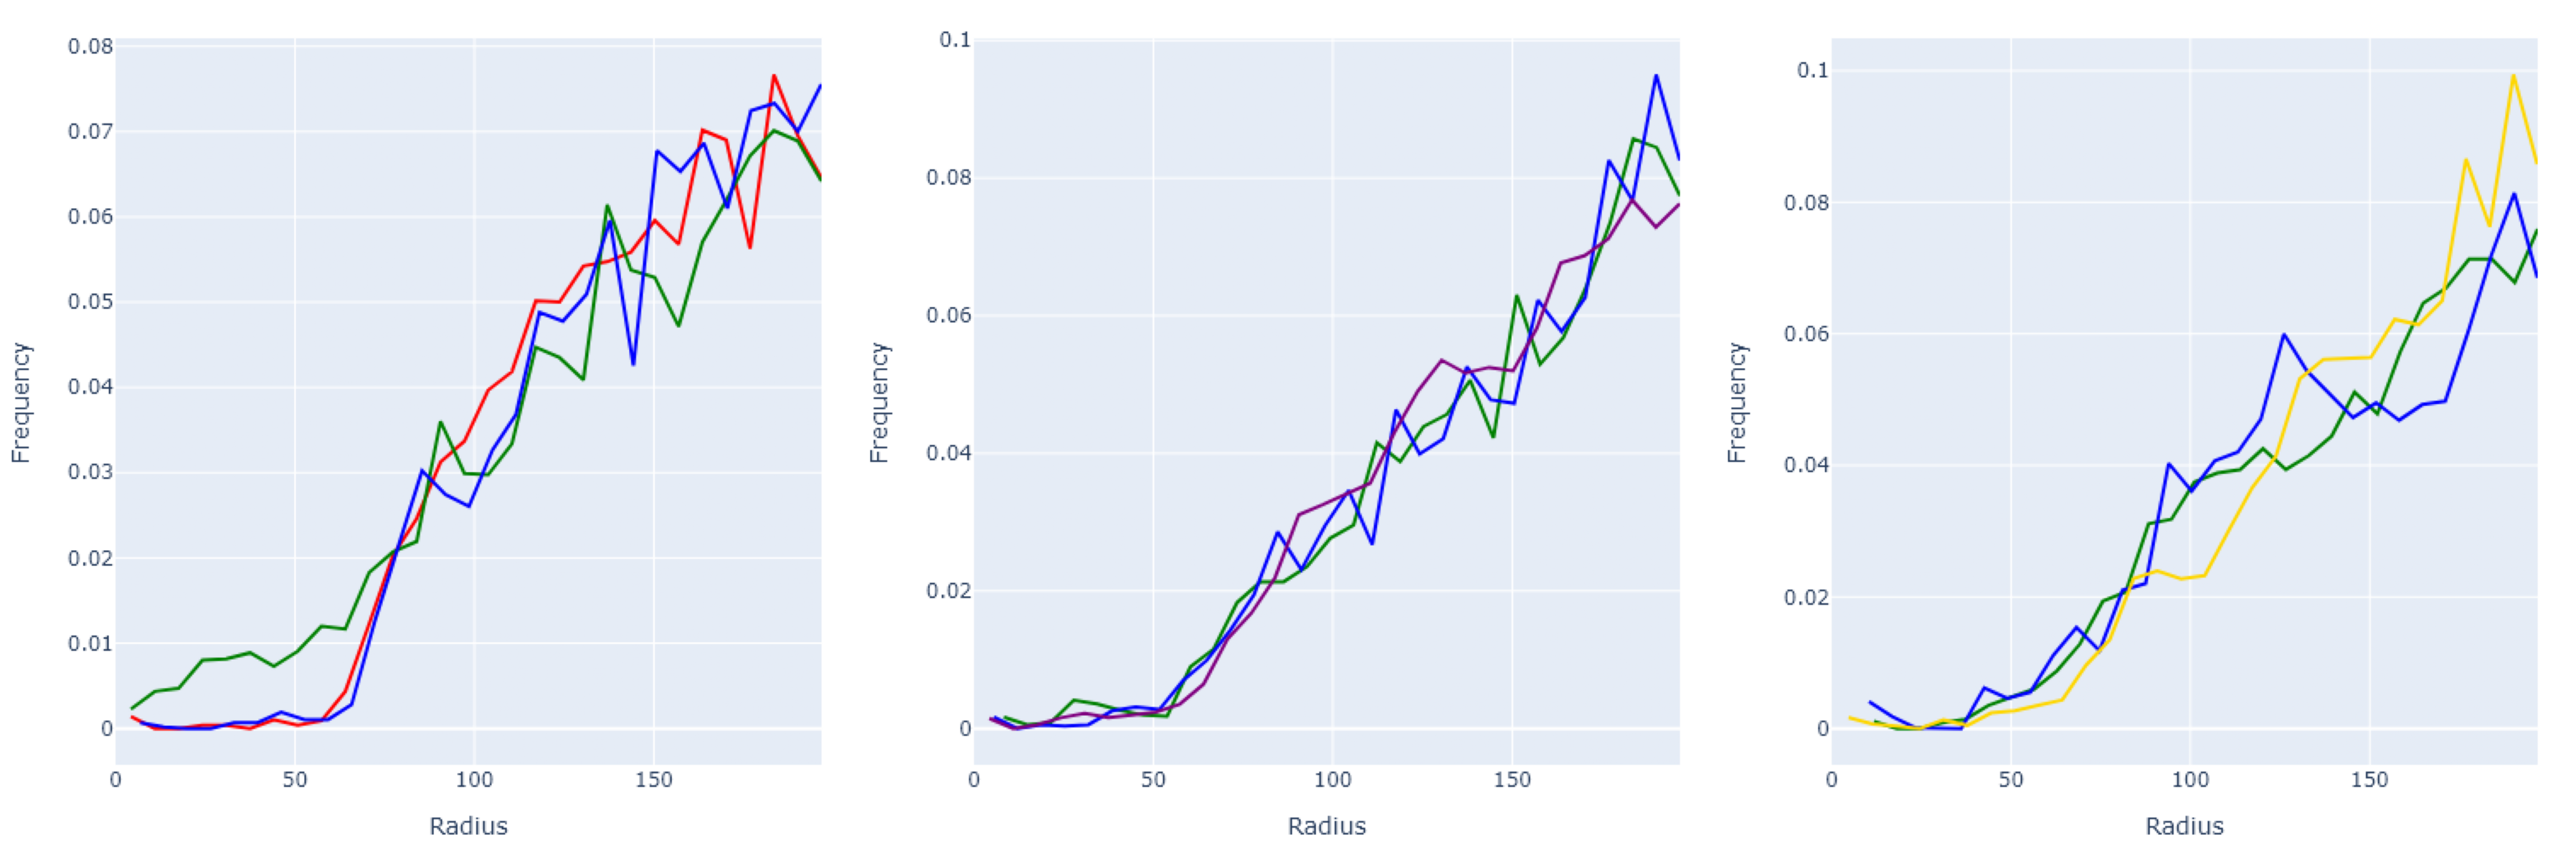

In [284]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of image names
image_names = [
    'DMMP-radii-line', 'MP-radii-line',
    'MPA-radii-line', 
]

# Create a figure with a 3x3 grid layout
fig, axes = plt.subplots(1, 3, figsize=(50, 20))

# Loop through the image names and add each image to the grid
for i, ax in enumerate(axes.flat):
    img_path = f'./output_distribution/{image_names[i]}.png'
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')  # Remove axis labels and ticks

# Set the background color to white
fig.patch.set_facecolor('white')

# Save the merged image
plt.tight_layout()
plt.savefig('./output_distribution/merged_radii_image.png')
plt.show()